In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json

from sklearn.metrics import adjusted_rand_score
from more_itertools import flatten
from scipy.special import gammaln, digamma
from scipy.stats import gamma

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

colours = [(208/255, 28/255, 139/255),
           (241/255, 182/255, 218/255),
           (184/255, 225/255, 134/255),
           (77/255, 172/255, 38/255)]

### Function for data extraction

In [10]:
def data_and_param_extract(idx, N_runs):
    ## LOAD RELEVANT DATA
    base_path = "analyses/simulation_studies/simulation_output/simulation_study_2/"

    output_dict = dict()

    ## alpha
    alpha_list = []
    for j in range(N_runs):
        file_path = base_path + f"alpha/alpha_store_{idx}_{j}.pkl"
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        f.close()
        alpha_list.append(data)

    ## beta
    beta_list = []
    for j in range(N_runs):
        file_path = base_path + f"beta/beta_store_{idx}_{j}.pkl"
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        f.close()
        beta_list.append(data)

    ## tau
    tau_list = []
    for j in range(N_runs):
        file_path = base_path + f"tau/tau_store_{idx}_{j}.pkl"
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        f.close()
        tau_list.append(data)

     ## group changes
    group_changes_list = []
    for j in range(N_runs):
        file_path = base_path + f"group_changes/group_changes_list_{idx}_{j}.pkl"
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        f.close()
        group_changes_list.append(data)

    
    ## group memberships
    group_memberships_list = []
    for j in range(N_runs):
        file_path = base_path + f"group_memberships/group_memberships_{idx}_{j}.pkl"
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        f.close()
        group_memberships_list.append(data)

    ## rate memberships
    rate_changes_list = []
    for j in range(N_runs):
        file_path = base_path + f"rate_changes/rate_changes_list_{idx}_{j}.pkl"
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        f.close()
        rate_changes_list.append(data)

    output_dict['alpha'] = alpha_list
    output_dict['beta'] = beta_list
    output_dict['tau'] = tau_list
    output_dict['group_changes'] = group_changes_list
    output_dict['group_memberships'] = group_memberships_list
    output_dict['rate_changes'] = rate_changes_list

    ## EXTRACT THE RELEVANT SIMULATION PARAMETERS
    param_path = "analyses/simulation_studies/simulation_parameters/simulation_study_2"
    with open(param_path + '/sim_params_simulation_study_2.json', 'r') as file:
        sim_params = json.load(file)
        sim_params_curr = sim_params[idx]

    output_dict['rho_matrix'] = np.array([[1, 1], [1, 1]])
    output_dict['num_nodes'] = 500
    output_dict['num_groups'] = 2
    output_dict['group_props'] = np.array([0.6, 0.4])
    output_dict['n_cavi'] = 3
    output_dict['int_length'] = 0.1
    output_dict['T_max'] = 5
    output_dict['rate_matrices'] = np.array(sim_params_curr[0])
    output_dict['delta'] = float(sim_params_curr[1])
    output_dict['change_gap_steps'] = float(sim_params_curr[2])

    # Rate change times
    first_change = 3
    second_change = first_change + output_dict['change_gap_steps']  * output_dict['int_length'] 
    rate_change_times_true = np.array([first_change, second_change])
    output_dict['rate_change_times_true'] = rate_change_times_true

    ## CONSTRUCT TRUE GROUP LABELS
    group_sizes = (output_dict['group_props'] * output_dict['num_nodes']).astype('int')
    output_dict['group_sizes'] = group_sizes
    missing_nodes = output_dict['num_nodes'] - group_sizes.sum()
    if missing_nodes != 0:
        if np.sum(np.where(group_sizes == 0)) != 0:
            group_sizes[np.where(group_sizes == 0)] = missing_nodes
        else:
            group_sizes[-1] += missing_nodes
    true_groups = np.array(
                list(flatten([[i]*j for i,j in enumerate(group_sizes)]))
                )
    output_dict['groups'] = true_groups

    return output_dict


In [89]:
df_rates = pd.DataFrame(columns=['delta', 'first_change', 'second_change', 'init_group_mean',
                               'pred_change_times', 'group_change_times'], index=range(12))

for sim in range(12):
    N_runs = 50
    data_dict = data_and_param_extract(sim, N_runs)
    df_rates.loc[sim, ['delta', 'first_change', 'second_change']] = (
        [data_dict['delta'], data_dict['rate_change_times_true'][0], 
         data_dict['rate_change_times_true'][1]]
    )

    df_rates.loc[sim, 'init_group_mean'] = [arr[0].mean() for arr in data_dict['group_memberships']] # Used for checks later
    df_rates.loc[sim,'pred_change_times'] = data_dict['rate_changes'] # Flagged rate changes
    df_rates.loc[sim,'group_change_times'] = data_dict['group_changes'] # Flagged group changes


### Function for computing CCD and DNF

In [146]:
def CCD_DNF(cps: list, flagged_changes: np.array, k_1: int, m_1: int):
    """
    Parameters:
        cps: list of true changes for group 1.
        flagged_changes: column 1 is flagged time, 2 and 3 are group indices.
        k)1, m_1: either 0 and 0 or 1 and 1, they account for labelling differences.
    """
    tot_detect = flagged_changes.shape[0] # Check on computation
    if tot_detect != 0: # Flags at least 1 change
        true_flags = 0 # T
        false_flags = 0 # D - T

        # Before first cp - all flags are incorrect here
        in_region = flagged_changes[(flagged_changes[:,0] <= cps[0])]
        false_flags += len(in_region)
        
        # Between first and second cp - only flags for group 1 to 1 are correct
        in_region = flagged_changes[(flagged_changes[:,0] > cps[0]) & (flagged_changes[:,0] <= cps[1] + 0.2)] # +0.2 to account for lag
        if len(in_region) != 0:
            mask = ((in_region[:,1] == k_1) & (in_region[:,2] == m_1))
            if np.sum(mask) > 0:
                true_flags += 1
                false_flags += (len(in_region) - 1)
            else:
                false_flags += len(in_region)
        
        # After second cp - only flags for group 1 to 1 are correct
        in_region = flagged_changes[(flagged_changes[:,0] > cps[1] + 0.2)] # +0.2 to account for lag
        if len(in_region) != 0:
            mask = ((in_region[:,1] == k_1) & (in_region[:,2] == m_1))
            if np.sum(mask) > 0:
                true_flags += 1
                false_flags += (len(in_region) - 1)
            else:
                false_flags += len(in_region)

        if (true_flags + false_flags) != tot_detect:
            raise ValueError("Number of true or false flags incorrect.")
            
        CCD = true_flags / len(cps)
        DNF = true_flags / tot_detect
    else: # Flags no changes
        CCD = 0
        DNF = 0

    return CCD, DNF

### Compute the CCD and DNF

In [147]:
T_max = 5
int_length = 0.1
second_change = df_rates['second_change'].unique().reshape((2,3))

CCD_arr = np.zeros((2, 6, 50))
DNF_arr = np.zeros((2, 6, 50))
row_count = -1
for delta in [0.1, 1]:
    row_count += 1; col_count = -1
    for i in range(2):
        for j in range(3):
            col_count += 1
            CCD_list = []; DNF_list = []
            change_time = second_change[i,j]
            index = df_rates[
                        (df_rates['delta'] == delta)
                        &
                        (df_rates['second_change'] == change_time)
                        ].index[0]
            
            pred_changes_list = df_rates.loc[index, 'pred_change_times']
            pred_changes_list = [np.array(entry) for entry in pred_changes_list]
            init_group_mean = df_rates.loc[index, 'init_group_mean']

            for ell in range(50):
                if init_group_mean[ell] == 0.6:
                    k_1 = 1; m_1 = 1
                else:
                    k_1 = 0; m_1 = 0
                pred_changes = pred_changes_list[ell]
                CCD_val, DNF_val = CCD_DNF([3, change_time], pred_changes, k_1, m_1)
                CCD_list.append(CCD_val); DNF_list.append(DNF_val)
            if len(CCD_list) != 0:
                CCD_arr[row_count, col_count, :] = CCD_list
            if len(DNF_list) != 0:
                DNF_arr[row_count, col_count, :] = DNF_list

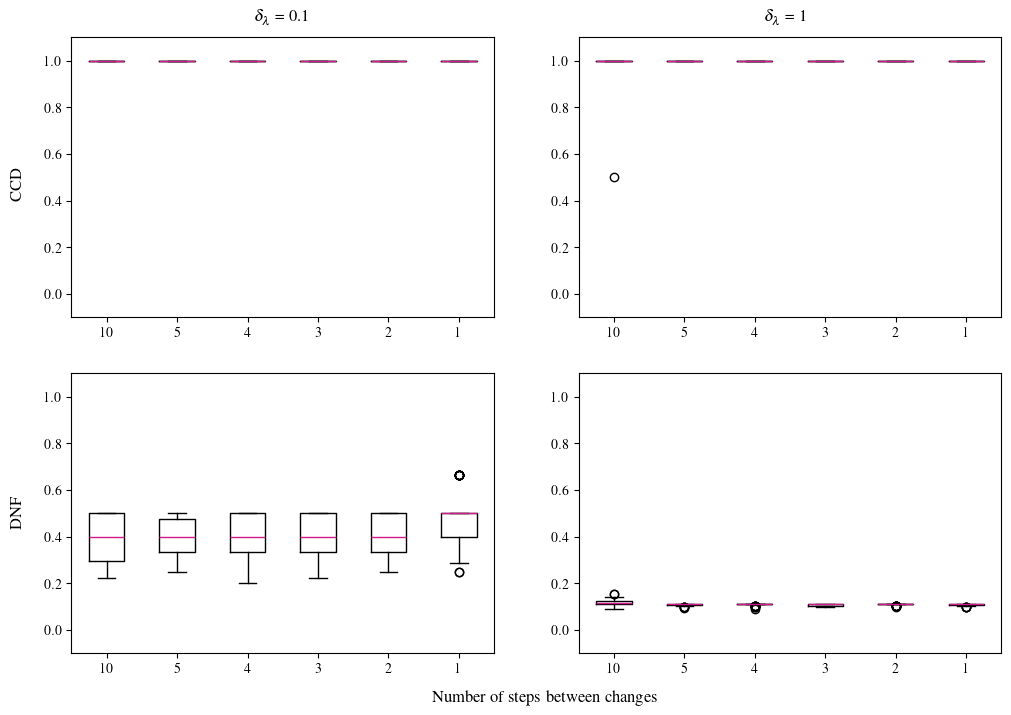

In [149]:
fig, axs = plt.subplots(2,2, figsize=(12,8))

gap_between_change = ((df_rates['second_change'].unique().astype('float') - 3) / 0.1).round().astype('int')

for i in range(2):
    for j in range(2):
        if i == 0:
            data = CCD_arr
        elif i == 1:
            data = DNF_arr
        axs[i,j].boxplot([data[j, gap, :] for gap in range(6)], positions=np.arange(6),
                          medianprops={'color': colours[0]})
        axs[i,j].set_xticklabels(gap_between_change)
        axs[i,j].set_ylim([-0.1,1.1])

fig.text(0.08, 0.68, 'CCD', ha='center', rotation='vertical', fontsize=12)
fig.text(0.08, 0.27, 'DNF', ha='center', rotation='vertical', fontsize=12)
fig.text(0.3, 0.9, r'$\delta_\lambda$ = 0.1', ha='center', fontsize=12)
fig.text(0.72, 0.9, r'$\delta_\lambda$ = 1', ha='center', fontsize=12)
fig.text(0.52, 0.05, 'Number of steps between changes', ha='center', fontsize=12);

plt.savefig('analyses/simulation_studies/simulation_output/simulation_study_2/plots/CCD_DNF.pdf')